# Transformer Model for PTB data 
As we concluded before, for PTB data, we apply the following preprocessing:   
resampling: Oversampling \
rescaling: Standard Scaler

If you don't have the original files: run the notebook `preprocessing_ptb_standard_oversampling.ipynb`     
**Input** : the original data.   
ptbdb_normal.csv  
ptbdb_abnormal.csv  

Output: DNN model trained  
model_trans_ptb.pkl  

In [1]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


## Read data 


In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline  # Use ImbPipeline for oversampling
import matplotlib.pyplot as plt
import seaborn as sns


RawFiles = dict({
    'train': data_path + 'ptb_train_standard_oversampling.csv', 
    'test': data_path + 'ptb_test_standard_oversamling.csv'  
})

OutputFiles = dict({
    'model': model_output_path +  'model_trans_ptb.pkl'
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



# Transformer with Standard Scaler and Oversampling

In [4]:
# Convert DataFrames to NumPy arrays
X_train = X_train.values
X_test = X_test.values

# Reshape the data to fit the LSTM model (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Check the shape of the data
print("X_train shape:", X_train.shape)  # should be (samples, timesteps, features)
print("X_test shape:", X_test.shape)    # should be (samples, timesteps, features)
  

X_train shape: (16809, 187, 1)
X_test shape: (4203, 187, 1)


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Set random seed for reproducibility
tf.random.set_seed(42)

# Optimized Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1, l2_reg=1e-4):
    # Self-Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed Forward Part
    x_ff = Dense(ff_dim, activation="relu", kernel_regularizer=l2(l2_reg))(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1], kernel_regularizer=l2(l2_reg))(x_ff)
    x = Add()([x, x_ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# Input Layer
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Add Transformer Encoder Blocks
x = transformer_encoder(inputs, head_size=64, num_heads=8, ff_dim=256, dropout=0.1, l2_reg=1e-4)
x = transformer_encoder(x, head_size=64, num_heads=8, ff_dim=256, dropout=0.1, l2_reg=1e-4)
x = transformer_encoder(x, head_size=64, num_heads=8, ff_dim=256, dropout=0.1, l2_reg=1e-4)

# Global Pooling and Dense Layers for Classification
x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)  # Reduced dropout for better generalization
x = Dense(128, activation="relu", kernel_regularizer=l2(1e-4))(x)  # Increased neurons in Dense layer
x = Dropout(0.2)(x)
outputs = Dense(1, activation="sigmoid")(x)  # Sigmoid for binary classification

# Define Model
model = Model(inputs, outputs)

# Optimizer
optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate for more stable training

# Compile Model
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Model Summary
model.summary()

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6)

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,  # Reduced batch size for better generalization
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 187, 1)    │      3,585 │ input_layer_2[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 187, 1)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 187, 1)    │          0 │ dropout_20[0][0], │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 187, 1)    │          2 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 187, 256)  │        512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 187, 256)  │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 187, 1)    │        257 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 187, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 187, 1)    │          2 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 187, 1)    │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 187, 1)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 187, 1)    │          0 │ dropout_23[0][0], │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 187, 1)    │          2 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 187, 256)  │        512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 187, 256)  │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 187, 1)    │        257 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 187, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_17[0][0]  

 Total params: 13,459 (52.57 KB)

 Trainable params: 13,459 (52.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 105s 371ms/step - accuracy: 0.4955 - loss: 0.6944 - val_accuracy: 0.4966 - val_loss: 0.6940 - learning_rate: 1.0000e-04
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 95s 361ms/step - accuracy: 0.4973 - loss: 0.6939 - val_accuracy: 0.4966 - val_loss: 0.6936 - learning_rate: 1.0000e-04
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 96s 366ms/step - accuracy: 0.4976 - loss: 0.6936 - val_accuracy: 0.4966 - val_loss: 0.6934 - learning_rate: 1.0000e-04
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 98s 373ms/step - accuracy: 0.4961 - loss: 0.6934 - val_accuracy: 0.4966 - val_loss: 0.6933 - learning_rate: 1.0000e-04
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 107s 407ms/step - accuracy: 0.4980 - loss: 0.6933 - val_accuracy: 0.4966 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 95s 362ms/step - accuracy: 0.4980 - loss: 0.6932 - val_accuracy: 0.4966 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 121s

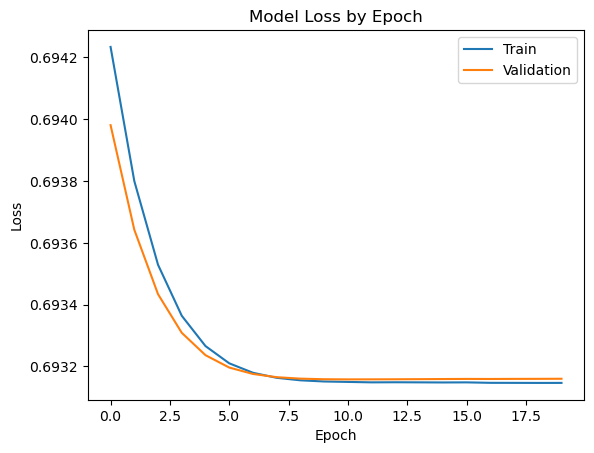

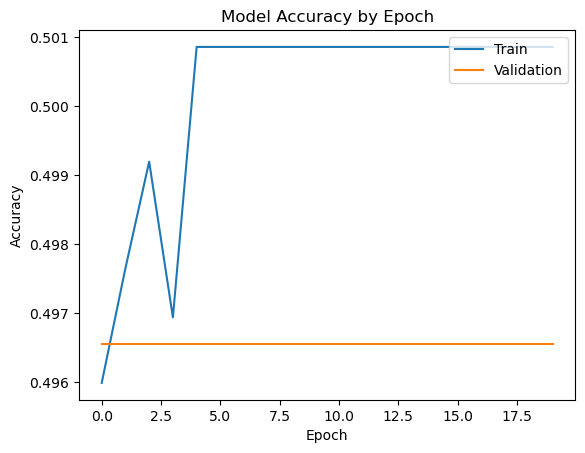

132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step
[[2087    0]
 [2116    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2087
           1       0.00      0.00      0.00      2116

    accuracy                           0.50      4203
   macro avg       0.25      0.50      0.33      4203
weighted avg       0.25      0.50      0.33      4203

F1 Score: 0.0


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [12]:
# Plotting the Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Making predictions
y_pred = model.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)

# Evaluating the model
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))
print(f"F1 Score: {f1_score(y_test, y_pred_class)}")
